In [ ]:
from google.colab import files
uploaded = files.upload()

Saving online_retail_II.xlsx to online_retail_II.xlsx


In [ ]:
import pandas as pd

# Load the 2010-2011 sheet
df = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')

# Show the first 5 rows
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Overview of dataset
df.info()

# Summary statistics
df.describe()

# Check for missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,0
Invoice,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
Price,0
Customer ID,135080
Country,0


In [ ]:
# Remove rows with missing Customer IDs
df = df.dropna(subset=['Customer ID'])

# Remove canceled orders (invoices that start with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Convert necessary columns to correct types
df['Customer ID'] = df['Customer ID'].astype(str)
df['Invoice'] = df['Invoice'].astype(str)

# Create a new column for total price
df['TotalPrice'] = df['Quantity'] * df['Price']

# Confirm changes
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


<Axes: title={'center': 'Top 10 Customers by Total Spend'}, xlabel='Customer ID'>

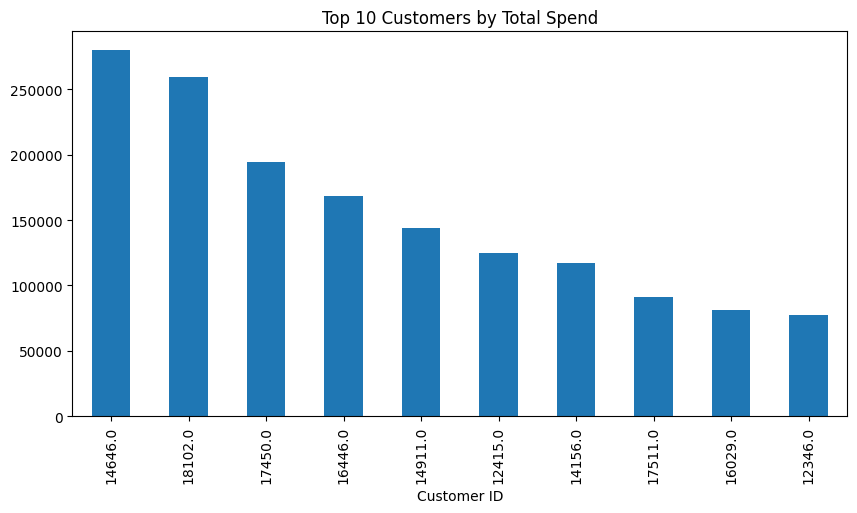

In [ ]:
# Top 10 customers by total spend
top_customers = df.groupby('Customer ID')['TotalPrice'].sum().sort_values(ascending=False).head(10)

top_customers.plot(kind='bar', figsize=(10, 5), title='Top 10 Customers by Total Spend')

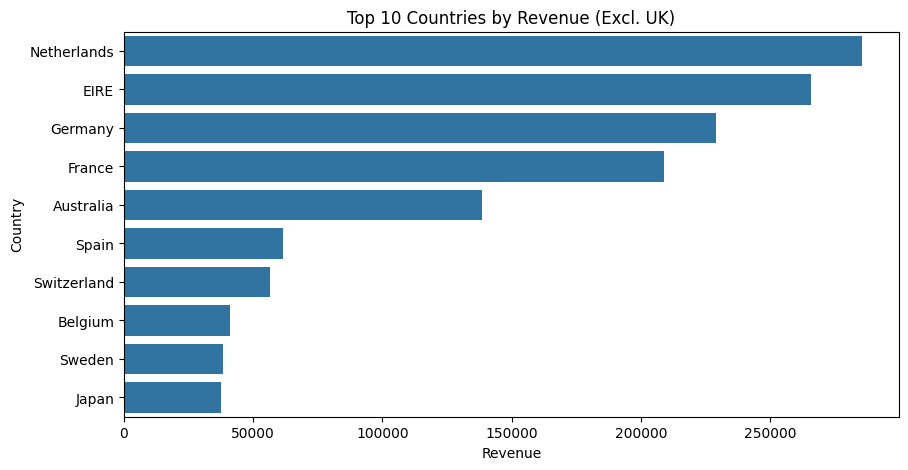

In [ ]:
top_countries = df[df['Country'] != 'United Kingdom'].groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 10 Countries by Revenue (Excl. UK)')
plt.xlabel('Revenue')
plt.ylabel('Country')
plt.show()

<Axes: title={'center': 'Monthly Revenue'}, xlabel='InvoiceMonth'>

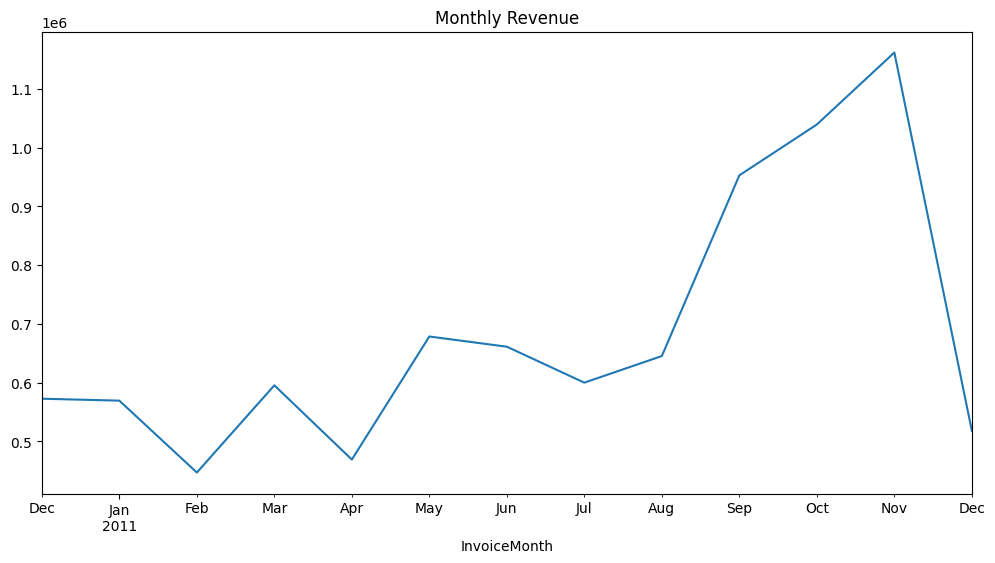

In [ ]:
# Convert InvoiceDate to datetime if not already
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Set InvoiceMonth
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

monthly_sales = df.groupby('InvoiceMonth')['TotalPrice'].sum()

monthly_sales.plot(kind='line', figsize=(12, 6), title='Monthly Revenue')

**Recency, Frequency, Monetary (RFM) Analysis**

What is RFM Analysis?
RFM analysis segments customers into different groups based on three key metrics:
1. Recency: How recently a customer made a purchase.
2. Frequency: How often a customer makes a purchase.
3. Monetary: How much money a customer spends.

In [ ]:
# Convert InvoiceDate to datetime format if not already
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Get the current date (the most recent date in the dataset)
max_date = df['InvoiceDate'].max()

# Recency, Frequency, Monetary (RFM) Analysis
rfm = df.groupby('Customer ID').agg(
    Recency=('InvoiceDate', lambda x: (max_date - x.max()).days),  # Recency as the difference from max date
    Frequency=('Invoice', 'nunique'),            # Frequency as the number of unique invoices
    Monetary=('TotalPrice', 'sum')               # Monetary as the sum of total spending
).reset_index()

# Display the first few rows of RFM
rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40


**Assign RFM Scores**

Now that we have the three RFM metrics, we'll assign scores to each customer for Recency, Frequency, and Monetary. We'll use quantiles (e.g., dividing the customers into 5 groups, with 1 being the worst and 5 being the best).

In [ ]:
# Assign quantile-based scores for Recency, Frequency, and Monetary
rfm['RecencyScore'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])  # Lower recency = higher score
rfm['FrequencyScore'] = pd.qcut(rfm['Frequency'], 5, duplicates='drop').cat.codes + 1  # Higher frequency = higher score
rfm['MonetaryScore'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])  # Higher spending = higher score

# Combine the scores to create a final RFM score
rfm['RFMScore'] = rfm['RecencyScore'].astype(int) + rfm['FrequencyScore'].astype(int) + rfm['MonetaryScore'].astype(int)

# Display the RFM data with scores
rfm.head()

,Customer ID,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMScore
0,12346.0,325,1,77183.60,1,1,5,7
1,12347.0,1,7,4310.00,5,4,5,14
2,12348.0,74,4,1797.24,2,3,4,9
3,12349.0,18,1,1757.55,4,1,4,9
4,12350.0,309,1,334.40,1,1,2,4


**Segment Customers Based on RFM Score**

With the scores assigned, we can create segments based on the total RFM score. Here’s an example of how to segment:

Segment 1: High value customers (Best customers)

Segment 2: Loyal customers

Segment 3: Recent buyers

Segment 4: At-risk customers

In [ ]:
# Create segments based on RFMScore
def rfm_segment(row):
    if row['RFMScore'] >= 12:
        return 'Best Customers'
    elif row['RFMScore'] >= 9:
        return 'Loyal Customers'
    elif row['RFMScore'] >= 6:
        return 'Recent Buyers'
    else:
        return 'At Risk'

# Apply the segment function
rfm['Segment'] = rfm.apply(rfm_segment, axis=1)

# Display the RFM data with segments
rfm.head()

,Customer ID,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMScore,Segment
0,12346.0,325,1,77183.60,1,1,5,7,Recent Buyers
1,12347.0,1,7,4310.00,5,4,5,14,Best Customers
2,12348.0,74,4,1797.24,2,3,4,9,Loyal Customers
3,12349.0,18,1,1757.55,4,1,4,9,Loyal Customers
4,12350.0,309,1,334.40,1,1,2,4,At Risk


**Visualizing RFM Segments**

Now, let's visualize the RFM segments to get a clearer picture of customer distribution:

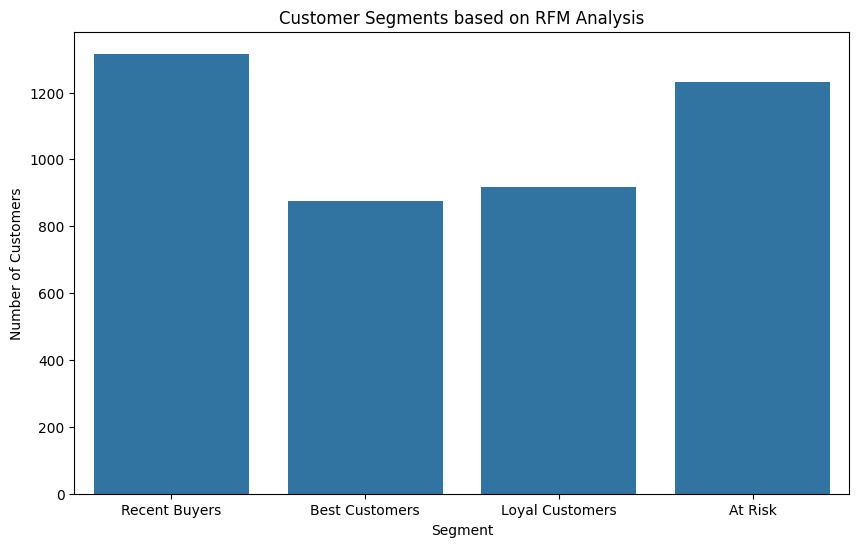

In [ ]:
# Plot the number of customers in each segment
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=rfm, x='Segment')
plt.title('Customer Segments based on RFM Analysis')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.show()

**Interpretation and Insights**
Here’s what each RFM segment means:
1. Best Customers: These are your high-value customers. They have made recent purchases, purchase frequently, and spend a lot. Focus on retention strategies and exclusive offers.
2. Loyal Customers: These customers purchase frequently but might not have made a purchase recently. Engage them with personalized marketing or loyalty programs.
3. Recent Buyers: These customers have recently made a purchase but don’t do so often. Send them follow-up emails or offers to encourage repeat business.
4. At Risk: These customers haven't purchased in a while and are at risk of churning. A targeted re-engagement campaign is needed to win them back.

**Save the RFM Analysis Results**
 You can save the RFM results to a CSV file for reporting:

In [ ]:
# Save the RFM analysis to a CSV file
rfm.to_csv('rfm_analysis_results.csv', index=False)

**Visualize Each RFM Metric**

Go beyond segments. Help business stakeholders see the distribution of Recency, Frequency, and Monetary:

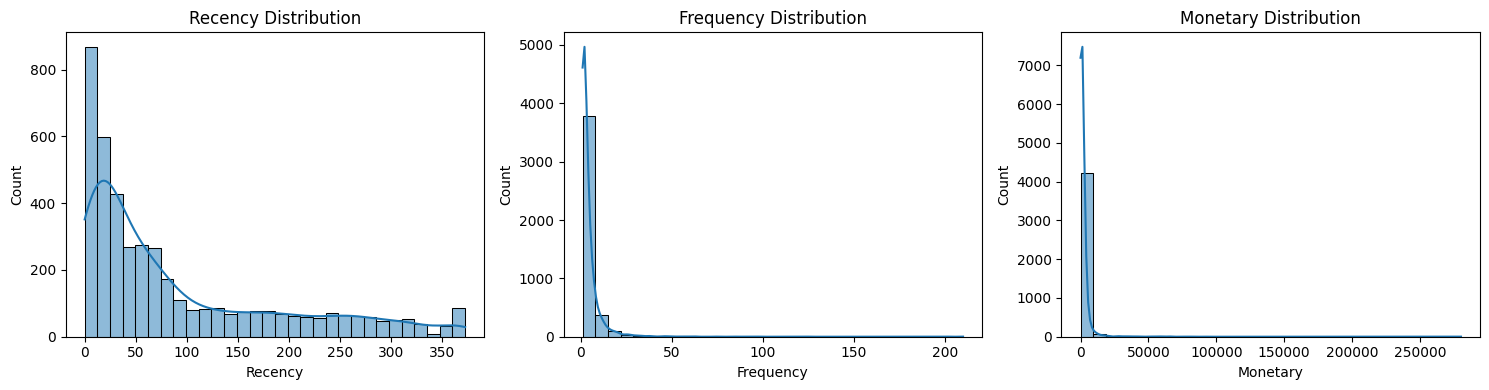

In [ ]:
# Visualizing distribution of each metric
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], bins=30, kde=True)
plt.title('Recency Distribution')

plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], bins=30, kde=True)
plt.title('Frequency Distribution')

plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], bins=30, kde=True)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

**Based on RFM segments:**
- Offer loyalty rewards to “Best Customers”
- Upsell/cross-sell to “Loyal Customers”
- Engage “Recent Buyers” with feedback forms
- Retarget “At Risk” customers with discounts

In [ ]:
from google.colab import files
files.download('rfm_analysis_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>